# Conv Vs Salinity 

In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import numpy as np
import xesmf as xe
import xarray as xr

import gsw
import copy

In [18]:
from dask_gateway import Gateway
gateway = Gateway()
# cluster = GatewayCluster()
options = gateway.cluster_options()

options.worker_cores = 4 # 16 #16 / 4
options.worker_memory = 16 # 32 #32 / 8  

cluster = gateway.new_cluster(options)

cluster.adapt(minimum = 2, maximum = 150)

client = cluster.get_client() 
cluster

In [23]:
client.close()
cluster.close()

In [3]:
# get cm4 so and thetao data ('gn' without regriding)
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
col = open_catalog(url).climate.cmip6_gcs()

dslist = col.search(variable_id = ['so', 'thetao'], table_id = 'Omon', experiment_id = 'piControl', 
           source_id = 'GFDL-CM4', grid_label = 'gn')
ds = dslist['CMIP.NOAA-GFDL.GFDL-CM4.piControl.Omon.gn'].to_dask()
ds = ds.squeeze('member_id').reset_coords('member_id', drop = True)

In [4]:
convinx_ross = xr.open_dataset('convinx_ross_cm4.nc').thetao

In [5]:
convinx_weddell = xr.open_dataset('convinx_weddell_cm4.nc').thetao

In [6]:
mldzscore = xr.open_dataset('mldzscore_cm4.nc').__xarray_dataarray_variable__

In [7]:
ds_weddell = ds.sel(x = slice(-60, 30), y = slice(-90, -60))  
ds_ross = ds.sel(x = slice(-210, -135), y = slice(-90, -60)) 

In [8]:
mldzscore_ws = mldzscore.sel(x = slice(-60, 30), y = slice(-90, -60))  
mldzscore_rs = mldzscore.sel(x = slice(-210, -135), y = slice(-90, -60)) 

In [13]:
conv_so_ws = ds_weddell.so.where(mldzscore_ws>2).isel(lev = 0).mean(dim = 'x').mean(dim = 'y')
conv_so_rs = ds_ross.so.where(mldzscore_rs>2).isel(lev = 0).mean(dim = 'x').mean(dim = 'y')

In [16]:
conv_so_ws_ann = conv_so_ws.groupby('time.year').mean('time')
conv_so_ws_sep = list(conv_so_ws.groupby('time.month'))[8][-1]

In [17]:
conv_so_rs_ann = conv_so_rs.groupby('time.year').mean('time')
conv_so_rs_sep = list(conv_so_rs.groupby('time.month'))[8][-1]

In [24]:
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

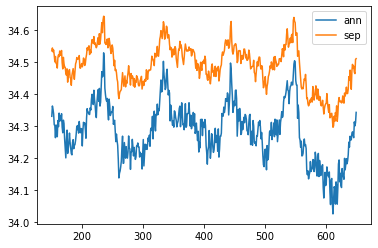

In [37]:
plt.plot(conv_so_rs_ann.year, conv_so_rs_ann)
plt.plot(conv_so_rs_ann.year, conv_so_rs_sep)

plt.legend(['ann','sep'])

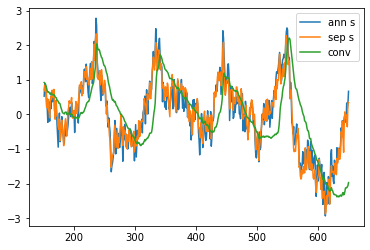

In [38]:
conv_ind = convinx_ross * -1
conv_so_ann = (conv_so_rs_ann - conv_so_rs_ann.mean('year'))/conv_so_rs_ann.std('year')
conv_so_sep = (conv_so_rs_sep - conv_so_rs_sep.mean('time'))/conv_so_rs_sep.std('time')

plt.plot(conv_ind.year, conv_so_ann)
plt.plot(conv_ind.year, conv_so_sep)
plt.plot(conv_ind.year, conv_ind)

plt.legend(['ann s','sep s','conv'])


In [25]:
def lag_cor(x,y,lag, c, l):
    stat=[]
    from scipy import stats
    for i in range(2*lag):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])
        stat.append(r_value)
    x=np.linspace(-lag,lag+1, 2*lag)
    plt.grid(True,which="both",ls="-", color='0.65')
    plt.plot(x, stat, c, label=l, linewidth=3.0)
    plt.xlabel('Year lag')
    plt.ylabel('r')

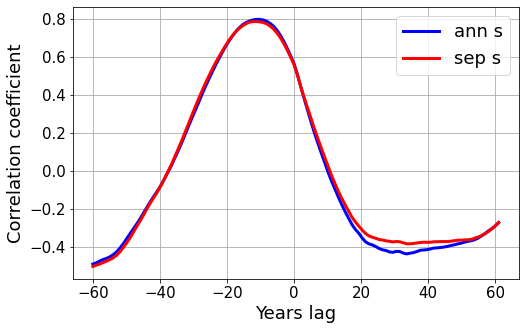

In [40]:
lag_time = 60

fig = plt.figure(figsize = (8,5))
lag_cor(conv_ind, conv_so_ann, lag_time,'b','ann s')
lag_cor(conv_ind, conv_so_sep, lag_time,'r','sep s')

''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 18)
# plt.title('Lagged correlation (Ross Sea Convection index), year {}-{}, {}'.format(start_year, end_year, model_name), fontsize=18)

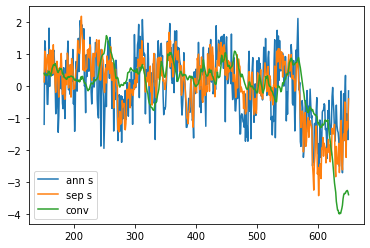

In [41]:
conv_ind = convinx_weddell * -1
conv_so_ann = (conv_so_ws_ann - conv_so_ws_ann.mean('year'))/conv_so_ws_ann.std('year')
conv_so_sep = (conv_so_ws_sep - conv_so_ws_sep.mean('time'))/conv_so_ws_sep.std('time')

plt.plot(conv_ind.year, conv_so_ann)
plt.plot(conv_ind.year, conv_so_sep)
plt.plot(conv_ind.year, conv_ind)

plt.legend(['ann s','sep s','conv'])

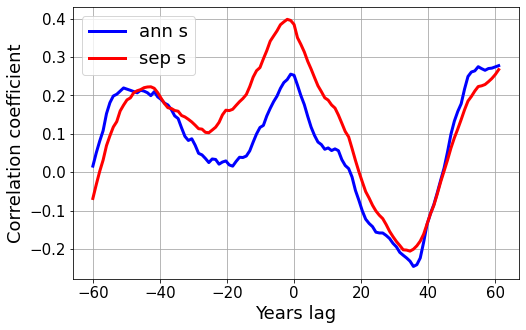

In [42]:
lag_time = 60

fig = plt.figure(figsize = (8,5))
lag_cor(conv_ind, conv_so_ann, lag_time,'b','ann s')
lag_cor(conv_ind, conv_so_sep, lag_time,'r','sep s')

''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 18)
# plt.title('Lagged correlation (Ross Sea Convection index), year {}-{}, {}'.format(start_year, end_year, model_name), fontsize=18)